In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
from IPython.display import display, clear_output
import ipywidgets as widgets
import pickle

from utils.placecell_functions import *
from utils.placecell_ploting import *
from utils.placecell_classes import data_loader, animal_widgets

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Data loading and variable declaration

In [3]:
data_dir = "../data/"
save_location = "../output_data/"
output_dir = "../output_figs/"

exp_sets = ['mcherry']
data_sets = ['Day2 - Squ-Tri-Tri','Day4 - Tri-Tri-Tri', 'Day5 - Tri-OptoTri-Tri', 'Day6 - Tri-OptoHex-Hex']

data_titles = ['Day2 - Familiar - Novel - Novel','Day4 - Familiar - Familiar - Familiar', 'Day5 - Familiar - OptoFamiliar - Familiar', 'Day6 - Familiar - OptoNovel - Novel']
session_names = [["Familiar", "Novel", "Novel"],["Familiar", "Familiar", "Familiar"],["Familiar", "OptoFamiliar", "Familiar"],["Familiar", "OptoNovel", "Novel"]]

data_filenames = ['ratemap_structure_day2.mat','ratemap_structure_day4.mat','ratemap_structure_day5.mat','ratemap_structure_day6.mat']


opto_actual_bins = [8, 20] #These are the zones that contained opto frames but the edges hardly had any
control_actual_bins = [21, 33] #This is the oposite of that zone. 
opto_bins = [10,18] # inclusive and based on zero index (added +1 when indexing)
control_bins = [21,29] # inclusive and based on zero index (added +1 to second element when indexing)


# colour palettes used for the plotting
purple_green_pallette = [(0.24423453, 0.20678459, 0.41985299), (0.29215894, 0.76144162, 0.67886578)]
purple_orange_pallette = [(0.24423453, 0.20678459, 0.41985299), (0.9411764705882353, 0.5607843137254902, 0.2901960784313726)]

purple_green_pallette_point = [(0.44423453, 0.40678459, 0.61985299), (0.29215894, 0.76144162, 0.67886578)]
purple_orange_pallette_point = [(0.44423453, 0.40678459, 0.61985299), (0.9490196078431372, 0.6784313725490196, 0.45098039215686275)]


joint_pal = [purple_orange_pallette, purple_green_pallette]
joint_pal_point = [purple_orange_pallette_point, purple_green_pallette_point]


### Define and show widgets
Using ipython widgets create and show widgets for data display option
- Could add observers for each widget to run the data processing step

In [4]:
# callback function to redraw widgets when dataset changes
def update_widgets(change):
    animals.create_widget(output_widget)
    

sort_by = widgets.RadioButtons(
        options=['Session 1', 'Session 2', 'Session 3'],
        index = 1,
        description='Ratemap to align to:',
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    )

activity_type = widgets.Select(
                options=["All activity","Place activity"],
                index=0,
                rows = 2,
                description='Activity type:',
                disabled=False,
                style= {'description_width': 'initial'}
            )

show_opto = widgets.Checkbox(
            value=False,
            description='Show optozone',
            disabled=False,
            indent=False
        )

ratemap_type = widgets.Select(
                options=["All cell rates","Place cells"],
                index=0,
                rows = 2,
                description='Ratemap type:',
                disabled=False,
                style= {'description_width': 'initial'}
            )


# create an instance of the data loader
data = data_loader(data_dir, exp_sets, data_sets, data_filenames, data_titles, session_names)

# observe when the data object changes
data.data_widget.observe(update_widgets, names = 'value')

#create an output widget that will hold the FOV image or the selection widget
output_widget = widgets.Output() 

#create animals widgets
animals = animal_widgets(output_widget, data)

#display all of the widgets
display(data.exp_widget)
display(data.data_widget)
display(animals.create_widget(output_widget)) 
display(activity_type)
display(ratemap_type)
display(sort_by)
display(show_opto)


RadioButtons(description='Experiments:', options=('mcherry',), value='mcherry')

RadioButtons(description='Dataset:', options=('Day2 - Squ-Tri-Tri', 'Day4 - Tri-Tri-Tri', 'Day5 - Tri-OptoTri-…

Output()

Select(description='Activity type:', options=('All activity', 'Place activity'), rows=2, style=DescriptionStyl…

Select(description='Ratemap type:', options=('All cell rates', 'Place cells'), rows=2, style=DescriptionStyle(…

RadioButtons(description='Ratemap to align to:', index=1, options=('Session 1', 'Session 2', 'Session 3'), val…

Checkbox(value=False, description='Show optozone', indent=False)

### Process data based on widget choice
From each widget obtain the selection choice and process the data.

In [5]:
# get widgets values and process data
animal_id = animals.selection.value
ids_to_pool = animals.ids_to_pool.value
sort_by_index = sort_by.index
compare_to_place = activity_type.index
plot_opto = show_opto.value

placecell_rates_dict = data.placecell_rates_dict
placecell_info_dict = data.placecell_info_dict

raw_rates_dict = data.raw_rates_dict
#raw_rates_info_dict = data.allcell_info_dict

sub_titles = data.sub_titles
data_set_to_plot = data.data_set_to_plot
title_for_data = data.title_for_data 
display_placecells = ratemap_type.index


# Select which data to be included in analysis
if animal_id == 'pooled data':
    #concatonate all of the animals ontop of eachother into a list
    placecell_rates = create_pooled_data(placecell_rates_dict,ids_to_pool)
    placecell_spatial_info = create_pooled_data(placecell_info_dict,ids_to_pool)
    raw_rates = create_pooled_data(raw_rates_dict,ids_to_pool)
    rates_average, rates_sem = get_pooled_average_rates(raw_rates_dict,ids_to_pool)
    coors_diags_mean, coors_diags_sem, opto_zone_diag, ctrl_zone_diag, opto_zone_avg, control_zone_avg = get_pooled_avg_corrs(raw_rates_dict,
                                                                                                                              placecell_rates_dict,
                                                                                                                              sort_by_index,
                                                                                                                              compare_to_place,
                                                                                                                              ids_to_pool,
                                                                                                                              opto_bins,
                                                                                                                              control_bins)
else:
    placecell_rates = placecell_rates_dict[animal_id]
    raw_rates = raw_rates_dict[animal_id]
    rates_average = get_average_rates(raw_rates_dict,animal_id)


# sort the ratemaps based on the user input
compare_rates = placecell_rates[sort_by_index]
sort_id, sort_index = sort_ratemaps(compare_rates)

# using the indices of sort_id Sort each placecell and rawrates  DataFrames in the list of dataframes and s and convert 
place_rates_sorted = [df.reindex(sort_id).fillna(0) for df in placecell_rates]
raw_rates_sorted = [df.reindex(sort_id).fillna(0) for df in raw_rates]
spatial_info_sorted = [df.reindex(sort_id).fillna(0) for df in placecell_spatial_info]

#get the placefield center for sorted ratemaps
place_rates_sorted_centers = [get_placecell_centers(df) for df in place_rates_sorted]
raw_rates_sorted_centers = [get_placecell_centers(df) for df in raw_rates_sorted]


# Proccess which rate maps to display          
if compare_to_place:
    display_rates = place_rates_sorted
else:
    display_rates = raw_rates_sorted
    display_rates[sort_by_index] = place_rates_sorted[sort_by_index]

# create the arrays to used for correlation
array1 = display_rates[sort_by_index].values
array2 = [df.values for df in display_rates]

# create the population vector correlation
place_rates_popveccorr = [create_corr_matrix(array1,array2[i]) for i in range(len(array2))]

# create the spatial correlation
place_rates_spatialcorr = [spatial_corr(array1,array2[i]) for i in range(len(array2))]


if animal_id != 'pooled data':

    coors_diags_mean = [np.diagonal(corrs) for corrs in place_rates_popveccorr]
    opto_zone_avg = [[np.mean(corrs[opto_bins[0]:opto_bins[1]+1,opto_bins[0]:opto_bins[1]+1])] for corrs in place_rates_popveccorr]
    control_zone_avg = [[np.mean(corrs[control_bins[0]:control_bins[1]+1,control_bins[0]:control_bins[1]+1])] for corrs in place_rates_popveccorr]

    opto_zone_diag = [[np.nanmean(id[opto_bins[0]:opto_bins[1]+1])] for id in coors_diags_mean]
    ctrl_zone_diag = [[np.nanmean(id[control_bins[0]:control_bins[1]+1])] for id in coors_diags_mean]


if display_placecells:
    rates_to_plot =  sort_placecells(placecell_rates)
else:
    rates_to_plot = display_rates






c:\Users\Matt\anaconda3\envs\placecell_processing\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Matt\anaconda3\envs\placecell_processing\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## Place cell event rates


In [6]:
# Function to plot event rates using seaborn and matplotlib
def plot_event_rates_seaborn(rates_average, rates_sem, line_thickness = 3, 
                             fontsize_scale = 2, 
                             legend_text = ['Session 1', 'Session 2'],
                             plot_opto = False,
                             line_pallette  = ['#357ba3', '#414387'],
                             fill_pallette = ['#357ba333', '#41438733'], 
                             plt_w = 5,
                             plt_h = 5):
    
    

    sns.set_theme(style="ticks", font='Arial', font_scale=fontsize_scale)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(plt_w, plt_h))
    ax.grid(True, which='major', axis='y', color='lightgrey', linestyle='-', linewidth=1)
    # Reverse loop to maintain similar order as the original plot
    for i, sessions in reversed(list(enumerate(rates_average.columns))):
        
        # Upper and lower bounds
        upper_bound = rates_average[sessions] + rates_sem[sessions]
        lower_bound = rates_average[sessions] - rates_sem[sessions]
        
        # Use fill_between for shaded area
        plt.fill_between(
            rates_average.index, 
            lower_bound, 
            upper_bound, 
            color=fill_pallette[i], 
            alpha=0.2,
            linewidth = 0 
        )
        
        # Plot the main event rate line
        sns.lineplot(
            x=rates_average.index, 
            y=rates_average[sessions], 
            label=legend_text[i],
            color=line_pallette[i], 
            linewidth = line_thickness
        )
    
    # Add axis labels and title (if needed)
    sns.despine()

    ax.set_xticks([0, 20, 40])
    ax.set_yticks([0, 0.1, 0.20])
    
    ax.set_ylim([0, 0.20])
    ax.set_xlim([0, 41])
    
    
    opto_actual_bins = [8, 20]
    if plot_opto:
        for zone in opto_actual_bins:
            ax.axvline(x = zone, linewidth=1.5, linestyle='--', color="tab:orange", alpha = 0.5)
            #ax.axvline(x = zone, linewidth=1.5, linestyle='--', color="cyan", alpha = 0.75)
        

    #x.legend(labels = legend_text)
    sns.move_legend(ax, "lower right",  ncol=1, frameon=False, title=None, fontsize = 12)
    
    plt.gca().spines['bottom'].set_linewidth(line_thickness)  # bottom axis
    plt.gca().spines['left'].set_linewidth(line_thickness)  # left axis
    plt.xlabel('Track position')
    plt.ylabel('Event rate')
    plt.tick_params(axis='both', which='both', length=0, pad = 8)
    #plt.tight_layout()
    
    return fig, ax

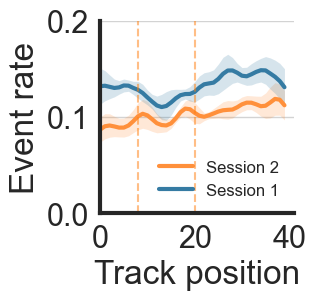

In [7]:
s2_s3_rates = rates_average.drop(columns = 'session_1')
s2_s3_sem = rates_sem.drop(columns = 'session_1')


linepal = ['#357ba3', '#ff903b']
fillpal = ['#357ba333', '#ff903b33']

fig, ax= plot_event_rates_seaborn(s2_s3_rates, s2_s3_sem, 
                                  fill_pallette = fillpal, 
                                  line_pallette= linepal,
                                  plt_h=2.5,
                                  plt_w=2.5,
                                  plot_opto=True,
                                  legend_text=['Session 1', 'Session 2'])



In [8]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'
save_path = f"../output_figs/eventrates/eventrates_mcherry.svg"
fig.savefig(save_path, format='svg')